In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import requests
import os
import torch
from PIL import Image, ImageDraw
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

import sys

sys.path.append("..")

In [3]:
tokens = {}
with open("/home/dbogdoll/mcity_data_engine/.secret", "r") as file:
    for line in file:
        key, value = line.strip().split("=")
        tokens[key] = value

os.environ["HF_TOKEN"] = tokens["HF_TOKEN"]

In [13]:
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub
from utils.data_loader import FiftyOneTorchDatasetCOCO, TorchToHFDatasetCOCO


try:
    dataset_v51 = load_from_hub("dbogdollumich/mcity_fisheye_v51")
except:
    dataset_v51 = fo.load_dataset("dbogdollumich/mcity_fisheye_v51")
pytorch_dataset = FiftyOneTorchDatasetCOCO(dataset_v51)
pt_to_hf_converter = TorchToHFDatasetCOCO(pytorch_dataset)
hf_dataset = pt_to_hf_converter.convert()

Loading dataset
{'val', 'train'}


Generating validation split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [36]:
from torch.utils.data import DataLoader


def zeroshot_collate_fn(batch):
    return list(zip(*batch))


data_loader = DataLoader(
    pytorch_dataset,
    batch_size=2,
    num_workers=8,
    pin_memory=True,
    collate_fn=zeroshot_collate_fn,
)

[[<PIL.Image.Image image mode=RGB size=1280x960 at 0x722B078EAFC0>, <PIL.Image.Image image mode=RGB size=1280x960 at 0x722B078EAC90>, <PIL.Image.Image image mode=RGB size=1280x960 at 0x722B078EB110>, <PIL.Image.Image image mode=RGB size=1280x960 at 0x722B12196210>, <PIL.Image.Image image mode=RGB size=1280x960 at 0x722AD59160F0>, <PIL.Image.Image image mode=RGB size=1280x960 at 0x722AD5914A10>, <PIL.Image.Image image mode=RGB size=1280x960 at 0x722AD5917440>, <PIL.Image.Image image mode=RGB size=1280x960 at 0x722AD5916060>], [{'boxes': tensor([[ 310.2863,  502.1461,   33.9681,   70.8233],
        [ 290.4559,  686.7031,   16.5307,   38.0223],
        [ 479.0335,  151.9207,   53.0998,   25.6115],
        [ 842.7024,  313.8354,   67.3734,   61.6840],
        [ 947.7999,  370.1340,   35.7385,   48.0628],
        [1000.7971,  399.1309,   28.0584,   39.5571],
        [1039.3646,  433.5495,   12.0229,   28.7538],
        [ 809.7269,  376.7461,   98.4444,   76.8060],
        [1026.5225,  465.4

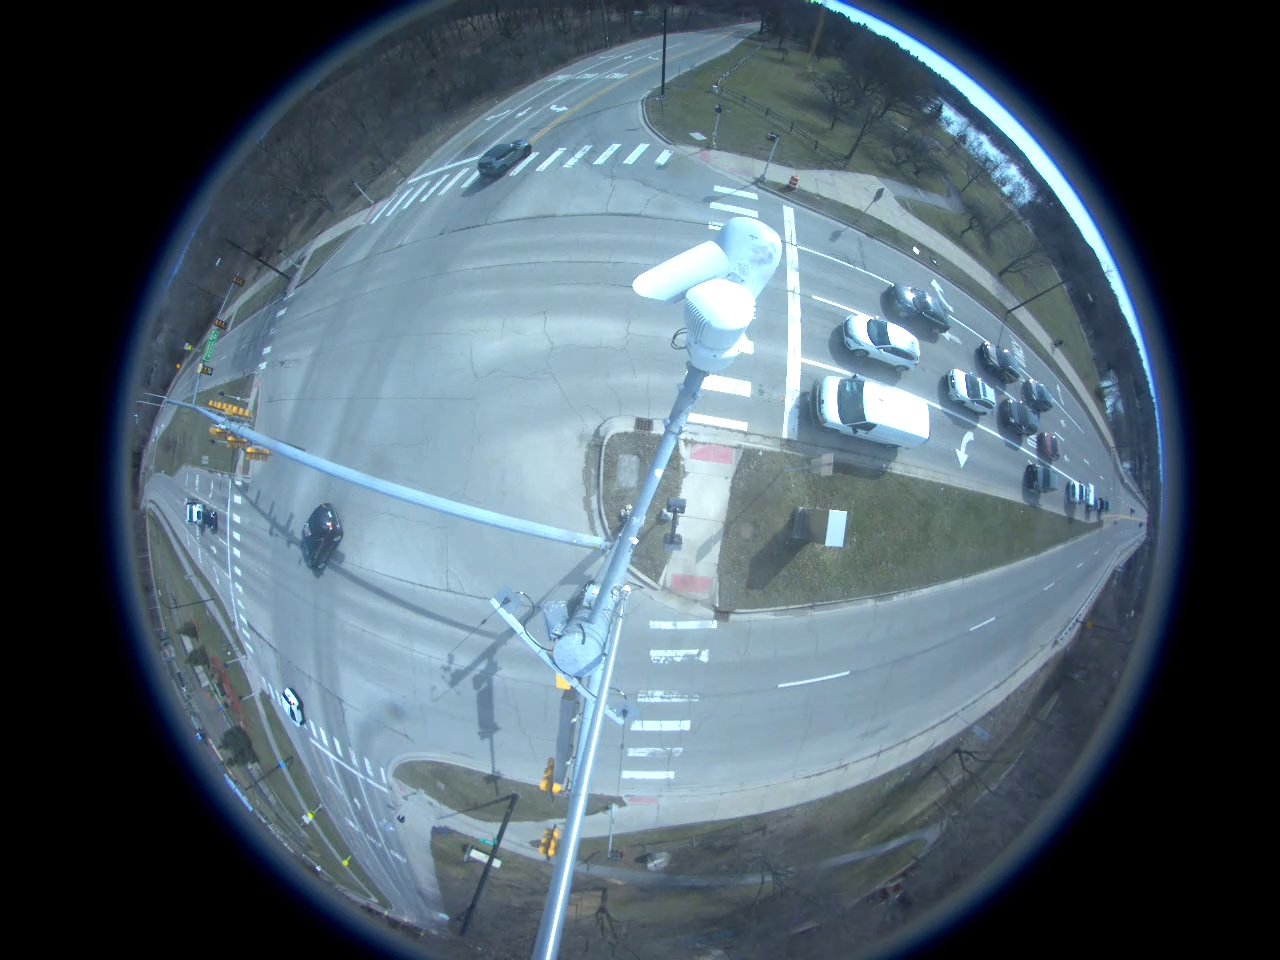

In [25]:
batch = next(iter(data_loader))
print(batch)
item = batch[0]
print(item)
image = item[0]
display(image)

In [48]:
model_id = "IDEA-Research/grounding-dino-tiny"
device = "cuda"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

text = "car.truck.bus.trailer.motorbike/cycler.pedestrian.van.pickup."
tokenized_text = processor.tokenizer(text, return_tensors="pt")
print(tokenized_text)
inputs = processor(images=image, text=text, return_tensors="pt").to(device)
print(inputs)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.3,
    target_sizes=[image.size[::-1]],
)
print(results)

{'input_ids': tensor([[  101,  2482,  1012,  4744,  1012,  3902,  1012,  9117,  1012,  5013,
          5638,  3489,  1013,  5402,  2099,  1012, 14662,  1012,  3158,  1012,
         15373,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
{'input_ids': tensor([[  101,  2482,  1012,  4744,  1012,  3902,  1012,  9117,  1012,  5013,
          5638,  3489,  1013,  5402,  2099,  1012, 14662,  1012,  3158,  1012,
         15373,  1012,   102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0'), 'pixel_values': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..

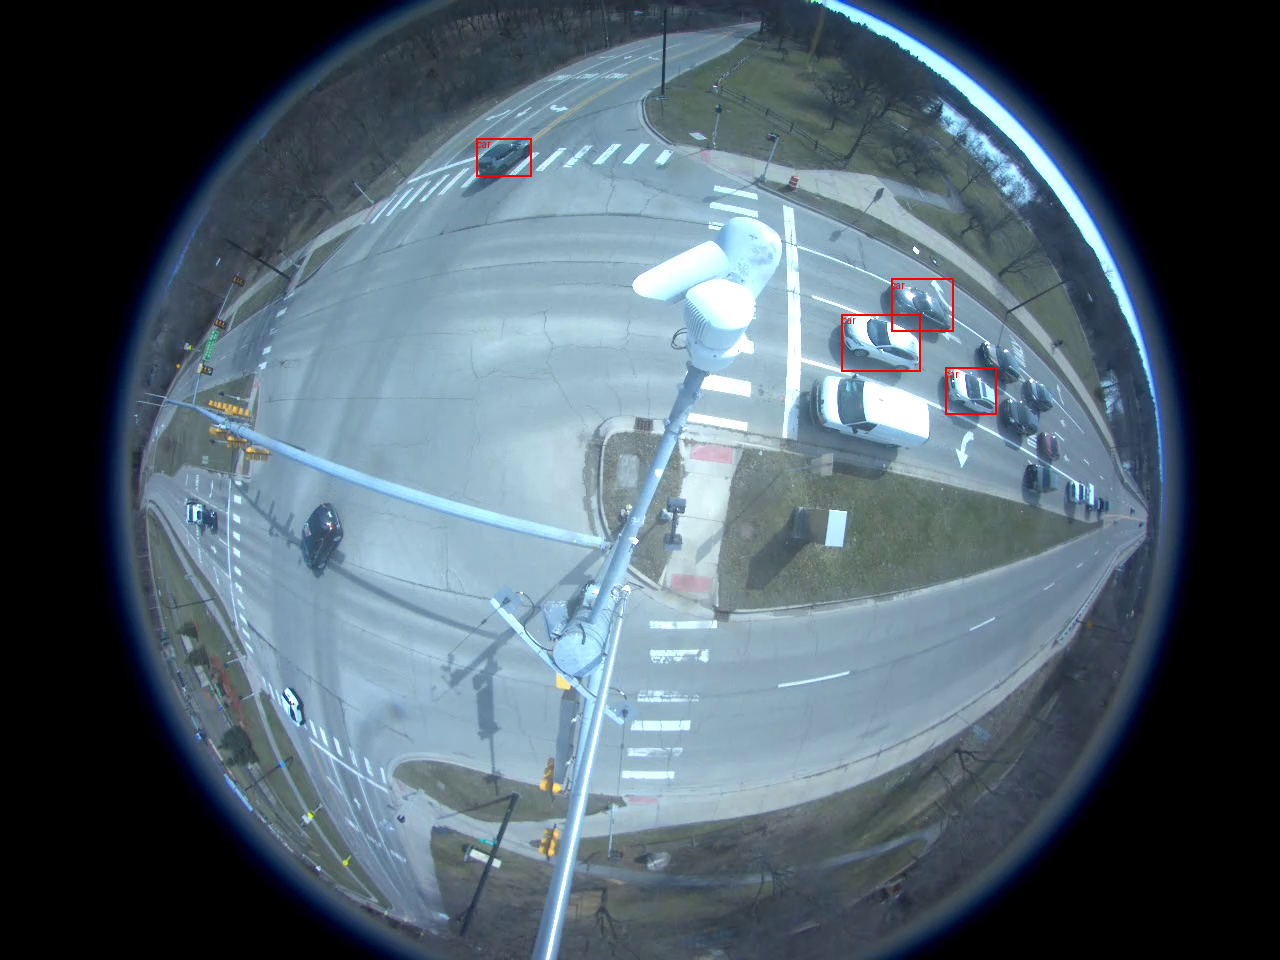

In [28]:
# Assuming 'results' contains the bounding boxes and labels
boxes = results[0]["boxes"]
labels = results[0]["labels"]

# Draw bounding boxes on the image
draw = ImageDraw.Draw(image)
for box, label in zip(boxes, labels):
    draw.rectangle(box.tolist(), outline="red", width=2)
    draw.text((box[0], box[1]), label, fill="red")

# Display the image
display(image)

In [55]:
batch_tokenized_text = [tokenized_text] * data_loader.batch_size

print(batch_tokenized_text)
batch_text = [text] * data_loader.batch_size
print(batch_text)

[{'input_ids': tensor([[  101,  2482,  1012,  4744,  1012,  3902,  1012,  9117,  1012,  5013,
          5638,  3489,  1013,  5402,  2099,  1012, 14662,  1012,  3158,  1012,
         15373,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}, {'input_ids': tensor([[  101,  2482,  1012,  4744,  1012,  3902,  1012,  9117,  1012,  5013,
          5638,  3489,  1013,  5402,  2099,  1012, 14662,  1012,  3158,  1012,
         15373,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}]
['car.truck.bus.trailer.motorbike/cycler.pedestrian.van.pickup.', 'car.truck.bus.trailer.motorbike/cycler.pedestrian.van.pickup.']
{'input_ids': tensor([[ 101, 2482, 1012,  ...,    0,    0,  

In [61]:
import os

batch_text = [text] * data_loader.batch_size
print(batch_text)

os.environ["TOKENIZERS_PARALLELISM"] = "true"
for images, targets in data_loader:
    inputs = processor(text=batch_text, images=images, return_tensors="pt").to(device)
    print("Inputs shape (first run):", {k: v.shape for k, v in inputs.items()})
    with torch.no_grad():
        outputs = model(**inputs)
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=0.2,
    )
    break  # Only 1 iteration

tokenized_texts = processor.tokenizer(
    batch_text,
    padding="max_length",
    return_tensors="pt",
    max_length=256,  # Adjust max_length to match vision hidden state
).to(device)
print("Tokenized texts shape:", {k: v.shape for k, v in tokenized_texts.items()})

for images, targets in data_loader:
    inputs = processor(text=None, images=images, return_tensors="pt").to(device)
    inputs.update(tokenized_texts)
    print("Inputs shape (second run):", {k: v.shape for k, v in inputs.items()})
    with torch.no_grad():
        outputs = model(**inputs)
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=0.2,
    )
    break  # Only 1 iteration

['car.truck.bus.trailer.motorbike/cycler.pedestrian.van.pickup.', 'car.truck.bus.trailer.motorbike/cycler.pedestrian.van.pickup.']
Inputs shape (first run): {'input_ids': torch.Size([2, 23]), 'token_type_ids': torch.Size([2, 23]), 'attention_mask': torch.Size([2, 23]), 'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066])}
Tokenized texts shape: {'input_ids': torch.Size([2, 256]), 'token_type_ids': torch.Size([2, 256]), 'attention_mask': torch.Size([2, 256])}
Inputs shape (second run): {'pixel_values': torch.Size([2, 3, 800, 1066]), 'pixel_mask': torch.Size([2, 800, 1066]), 'input_ids': torch.Size([2, 256]), 'token_type_ids': torch.Size([2, 256]), 'attention_mask': torch.Size([2, 256])}
